In [53]:
from cellgrid import CellGrid ,capped_distance_array
from MDAnalysis.lib.pkdtree import PeriodicKDTree
import numpy as np
from scipy.special import gammainc
from MDAnalysis.lib.distances import self_distance_array,distance_array
%matplotlib inline

In [58]:
def generate_slab(box,Npoints):
    points = np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]
    points = np.array(points,dtype=np.float32)
    return points

In [59]:
def cg_select_around(protein_particles,solvent_particles,maxdist,box):
    if box.shape == (6,):
        box1 = box[:3]
    else:
        box1 = box
    indx,dist = capped_distance_array(protein_particles,solvent_particles,maxdist,box1)
    mask = np.where(dist<maxdist)
    indices = (np.unique((indx[mask])[:,1]))
    return indices

def bf_select_around(protein_particles,solvent_particles,maxdist,box):
    distance = distance_array(protein_particles,solvent_particles,box)
    mask = np.where(distance<maxdist)[1]
    return np.unique(mask)

def kdtree_select_around(protein_particles,solvent_particles,maxdist,box):
    kdtree = PeriodicKDTree(box,bucket_size=10)
    kdtree.set_coords(solvent_particles)
    kdtree.search(protein_particles,maxdist)
    indices = kdtree.get_indices()
    return np.array(indices)

In [60]:
#Benchmark setting
box = np.array([100,100,100,90,90,90],dtype=np.float32)
Nprotein,Nsolvent = 1000,1000
maxdist = 6.0

In [61]:
##Initialize
slabheight = box[2]/2
new_box = box.copy()
new_box[2] = slabheight
slab_bot = generate_slab(new_box,Nprotein)
slab_top = generate_slab(new_box,Nsolvent) + np.array([0,0,slabheight],dtype=np.float32)

In [62]:
cg_selection = cg_select_around(slab_bot,slab_top, maxdist,box)
kdtree_selection = kdtree_select_around(slab_bot,slab_top,maxdist,box)
bf_selection = bf_select_around(slab_bot,slab_top,maxdist,box)

In [63]:
#Testing
np.testing.assert_equal(bf_selection,cg_selection)
np.testing.assert_equal(bf_selection,kdtree_selection)

In [64]:
%timeit -n 10 -r 3 kdtree_select_around(slab_bot,slab_top,maxdist,box)
%timeit -n 10 -r 3 bf_select_around(slab_bot,slab_top,maxdist,box)
%timeit -n 10 -r 3 cg_select_around(slab_bot,slab_top, maxdist, box)

35.8 ms ± 2.45 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
40.3 ms ± 1.02 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
2.58 s ± 517 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [65]:
#Benchmark scaling : neighbour selection  
# with increase in  density 

##Setting
box = np.array([100,100,100,90,90,90],dtype=np.float32)
slabheight = box[2]/2.
new_box = box.copy()
new_box[2] = slabheight
N = np.logspace(2,3,num=3,dtype='int32') #Both Nprotein,Nsolvent
maxdist = 6.0

In [67]:
##Benchmarks
time_kd,time_bf,time_cg = [],[],[]
func_dict = dict(KDtree=[kdtree_select_around,time_kd],BruteForce=[bf_select_around,time_bf],Cellgrid=[cg_select_around,time_cg])
for n in N:
    slab_bot = generate_slab(new_box,n)
    slab_top = generate_slab(new_box,n) + np.array([0,0,slabheight],dtype=np.float32)
    for key in func_dict:
        time = %timeit -q -o -n 1 -r 3 func_dict[key][0](slab_bot,slab_top,maxdist,box)
        func_dict[key][1].append([time.average,time.stdev])

In [68]:
#Output
for idx,value in enumerate(N):
    print("Number of Particles : Top => {}, Bottom => {}".format(value,value))
    for key in func_dict:    
        print("{} \t\t Average Time: {} Standard Deviation: {}".format(key,func_dict[key][1][idx][0],func_dict[key][1][idx][1]))
    print()

Number of Particles : Top => 100, Bottom => 100
KDtree 		 Average Time: 0.005694333332940005 Standard Deviation: 0.0004802813983799757
BruteForce 		 Average Time: 0.0008896666671110628 Standard Deviation: 0.0002517860661288117
Cellgrid 		 Average Time: 2.3050709999988612 Standard Deviation: 0.05676487268206319

Number of Particles : Top => 316, Bottom => 316
KDtree 		 Average Time: 0.01084633333327171 Standard Deviation: 0.0006041083398681291
BruteForce 		 Average Time: 0.00422700000005231 Standard Deviation: 0.00054563785231696
Cellgrid 		 Average Time: 2.3601086666664437 Standard Deviation: 0.07539668467131588

Number of Particles : Top => 1000, Bottom => 1000
KDtree 		 Average Time: 0.043358666667093836 Standard Deviation: 0.006565720744450134
BruteForce 		 Average Time: 0.03926499999943189 Standard Deviation: 0.0006962217082295912
Cellgrid 		 Average Time: 2.573954999998629 Standard Deviation: 0.24420356518752154



In [69]:
import matplotlib
import matplotlib.pyplot as plt

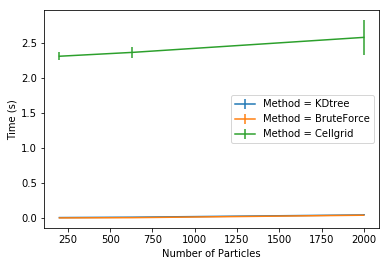

In [72]:
##Plots for visual comparison
for key in func_dict:
    avg_time,sd = np.array(func_dict[key][1],dtype=np.float32)[:,0],np.array(func_dict[key][1],dtype=np.float32)[:,1]
    plt.errorbar(N*2,avg_time,yerr=sd,label='Method = {}'.format(key))
    plt.legend()
    plt.xlabel('Number of Particles')
    plt.ylabel('Time (s)')

In [73]:
###Benchmarks for different cutoff radius and density of number of particles only for cellgrid

#Setting
box = np.array([100,100,100,90,90,90],dtype=np.float32)
slabheight = box[2]/2
new_box = box.copy()
new_box[2] = slabheight
N = np.logspace(2,3,num=3,dtype='int32') #Both Nprotein,Nsolvent
Maxdist = np.linspace(4,10,num=7,dtype=np.int32)

In [75]:
##Benchmarks
time_cg = []
for n in N:
    slab_bot = generate_slab(new_box,n)
    slab_top = generate_slab(new_box,n) + np.array([0,0,slabheight],dtype=np.float32)
    for maxdist in Maxdist:
        time = %timeit -q -o -n 1 -r 3 cg_select_around(slab_bot,slab_top,maxdist,box)
        time_cg.append([n,maxdist,time.average,time.stdev])

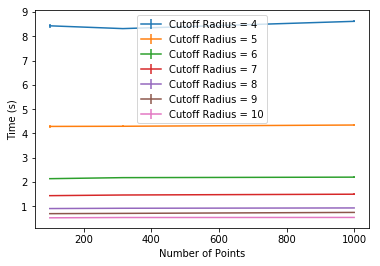

In [76]:
##Plot for visual comparison
arr = np.array(time_cg)
for maxdist in Maxdist:
    mask = (arr[:,1]==maxdist)
    npt,avg,sd = (arr[mask,:][:,0]),(arr[mask,:][:,2]),(arr[mask,:][:,3])
    plt.errorbar(npt,avg,yerr=sd,label='Cutoff Radius = {}'.format(maxdist))
    plt.legend()
    plt.xlabel('Number of Points')
    plt.ylabel('Time (s)')